In [ ]:
# !pip install odc-stats==1.0.6 --upgrade

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [15]:
import os
import json
import xarray as xr
import geopandas as gpd

import datacube
import matplotlib.pyplot as plt
from deafrica_tools.plotting import display_map
from deafrica_tools.dask import create_local_dask_cluster

from ndvi_tools.ndvi_climatology_plugin import NDVIClimatology

## Test functions without odc-stats

In [16]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:42501 Dashboard: /user/chad_extra/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [17]:
dc = datacube.Datacube(app="Vegetation_anomalies")

In [18]:
lat, lon = 34.5117, -5.9119
buffer = 0.05
# Set the range of dates for the climatology
time_range = ('2014', '2016')
resolution = (-60, 60)

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

In [19]:
# display_map(x=lon_range, y=lat_range)

In [20]:
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'measurements':['red','nir','pixel_quality'],
    'group_by':'solar_day'
#     'dask_chunks':dask_chunks
}

### grab data so we can use the geobox parameter to mimic a 'task'

In [21]:
task = dc.load(product='ls8_sr', dask_chunks={}, **query)

### grab lists of datatsets to mimic .db files

In [22]:
dss = dc.find_datasets(product=['ls7_sr', 'ls8_sr'], **query)

### set up an example config

In [23]:
config = dict(
    resampling="bilinear",
    bands=["red", "nir"],
    mask_band="QA_PIXEL",
    mask_filters=[["opening", 5], ["dilation", 5]],
    flags_ls57=dict(cloud="high_confidence", cloud_shadow="high_confidence"),
    flags_ls8=dict(
        cloud="high_confidence",
        cloud_shadow="high_confidence",
        cirrus="high_confidence",
    ),
)

### Run the plugin code

In [24]:
x=NDVIClimatology(**config)
ndvi = x.input_data(dss, task.geobox)
result = x.reduce(ndvi).compute()
print(result)

<xarray.Dataset>
Dimensions:             (y: 177, x: 162)
Coordinates:
  * y                   (y) float64 4.153e+06 4.153e+06 ... 4.142e+06 4.142e+06
  * x                   (x) float64 -5.752e+05 -5.752e+05 ... -5.656e+05
    spatial_ref         int32 6933
Data variables: (12/24)
    ndvi_clim_mean_jan  (y, x) float32 0.3827 0.4375 0.4961 ... 0.1848 0.4449
    ndvi_clim_mean_feb  (y, x) float32 0.7047 0.682 0.658 ... 0.1674 0.4631
    ndvi_clim_mean_mar  (y, x) float32 0.7762 0.7467 0.7512 ... 0.1703 0.432
    ndvi_clim_mean_apr  (y, x) float32 0.7524 0.7524 0.7531 ... 0.2865 0.5391
    ndvi_clim_mean_may  (y, x) float32 0.3464 0.3839 0.4191 ... 0.1683 0.4161
    ndvi_clim_mean_jun  (y, x) float32 0.214 0.228 0.2469 ... 0.08901 0.3435
    ...                  ...
    ndvi_clim_std_jul   (y, x) float32 0.03097 0.03286 ... 0.03922 0.03558
    ndvi_clim_std_aug   (y, x) float32 0.2016 0.1765 0.1484 ... 0.03567 0.04203
    ndvi_clim_std_sep   (y, x) float32 0.2698 0.2644 0.2552 ... 0.036

### Plot

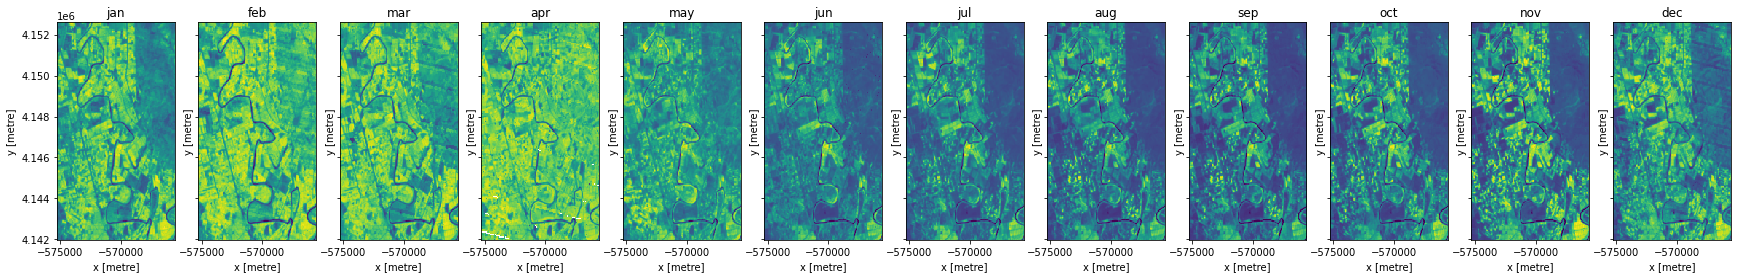

In [25]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['ndvi_clim_mean_'+j].plot.imshow(ax=ax[i], add_colorbar=False, vmin=0)
    ax[i].set_title(j)

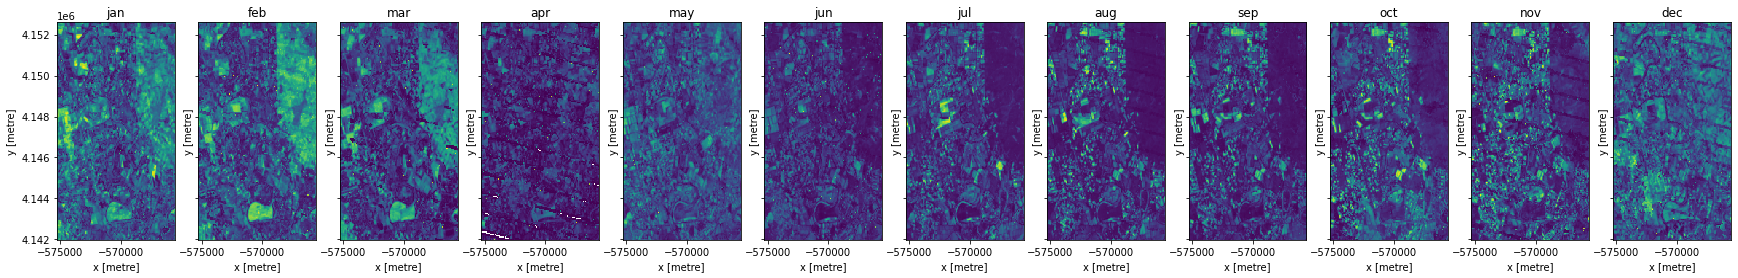

In [26]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['ndvi_clim_std_'+j].plot.imshow(ax=ax[i], add_colorbar=False)
    ax[i].set_title(j)

## Test functions with odc-stats

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [9]:
import os
# from ndvi_tools.ndvi_climatology_plugin import NDVIClimatology

### Generate tasks etc

In [2]:
# !odc-stats save-tasks --frequency annual --grid africa-30 --temporal-range 2014--P2Y ls7_sr-ls8_sr --frequency all --dataset-filter '{"collection_category": "T1"}'
# !odc-stats save-tasks --frequency annual --grid africa-30 --temporal-range 2014--P2Y ls8_sr --frequency all --dataset-filter '{"collection_category": "T1"}'

### Try running odc-stats using the config yaml and external plugin

In [14]:
from ndvi_tools.ndvi_climatology_plugin import NDVIClimatology

In [10]:
%%time
os.system("odc-stats run "\
          "ls7_sr-ls8_sr_2014--P2Y.db "\
          "--config=ndvi_climatology.yaml "\
          "--resolution=60 "\
          "--threads=4 "\
          "--memory-limit=29Gi "\
          "--location=file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version} "+str(1200)
         )

[2021-11-10 05:15:54,904] {_cli_run.py:139} INFO - Config overrides: {'filedb': 'ls7_sr-ls8_sr_2014--P2Y.db', 'threads': 4, 'memory_limit': '29Gi', 'output_location': 'file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version}'}
[2021-11-10 05:15:54,904] {_cli_run.py:158} INFO - Using this config: TaskRunnerConfig(filedb='ls7_sr-ls8_sr_2014--P2Y.db', aws_unsigned=True, plugin='ndvi_tools.ndvi_climatology_plugin.NDVIClimatology', plugin_config={'resampling': 'bilinear', 'bands': ['red', 'nir'], 'mask_band': 'QA_PIXEL', 'mask_filters': [['opening', 5], ['dilation', 5]], 'flags_ls57': {'cloud': 'high_confidence', 'cloud_shadow': 'high_confidence'}, 'flags_ls8': {'cloud': 'high_confidence', 'cloud_shadow': 'high_confidence', 'cirrus': 'high_confidence'}}, product={'name': 'ndvi_climatology', 'short_name': 'ndvi_climatology', 'version': '0.0.1', 'collections_site': 'explorer.digitalearth.africa', 'producer': 'digitalearthafrica.org', 'region_code_form

Traceback (most recent call last):
  File "/env/bin/odc-stats", line 8, in <module>
    sys.exit(main())
  File "/env/lib/python3.8/site-packages/click/core.py", line 1137, in __call__
    return self.main(*args, **kwargs)
  File "/env/lib/python3.8/site-packages/click/core.py", line 1062, in main
    rv = self.invoke(ctx)
  File "/env/lib/python3.8/site-packages/click/core.py", line 1668, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/env/lib/python3.8/site-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/env/lib/python3.8/site-packages/click/core.py", line 763, in invoke
    return __callback(*args, **kwargs)
  File "/env/lib/python3.8/site-packages/odc/stats/_cli_run.py", line 161, in run
    runner = TaskRunner(cfg, resolution=resolution, from_sqs=from_sqs)
  File "/env/lib/python3.8/site-packages/odc/stats/proc.py", line 45, in __init__
    mk_proc = resolve(cfg.plugin)
  File "/env/lib/python

256

In [ ]:
# !odc-stats run ls7_sr_2014--P2Y.db --config=ndvi_climatology.yaml --resolution=60 --threads=4 --memory-limit=29Gi --location=file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version}

In [ ]:
# taskdb = TaskReader('s3://deafrica-services/crop_mask_eastern/1-0-0/gm_s2_semiannual_all.db', product=op)
# task = taskdb.load_task(('2019--P1Y', t[0], t[1]))